#Dataset M5 Forecasting

#Objectifs
Le lab poursuit les objectifs suivants :

Explorer les données afin de comprendre leur structure et leurs tendances générales.

Visualiser l’évolution des ventes.

Utiliser les données disponibles pour entraîner des modèles RNN, LSTM et GRU afin de prédire les ventes futures.

# Installation des packages nécessaires

In [47]:
!pip install ydata-profiling


In [48]:
!pip install -q pmdarima
!pip install -q tensorflow

#IMPORTS ET MONTAGE GOOGLE DRIVE

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import pickle
import os
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuration matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Définir les chemins
BASE_PATH = '/content/drive/MyDrive/M5_Forecasting'
DATA_PATH = f'{BASE_PATH}/data'
MODELS_PATH = f'{BASE_PATH}/models'
NOTEBOOK_PATH = f'{BASE_PATH}/notebooks'

# Créer les dossiers s'ils n'existent pas
os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(NOTEBOOK_PATH, exist_ok=True)

print("✅ Google Drive monté avec succès!")
print(f"📁 Chemin base: {BASE_PATH}")
print(f"📁 Données: {DATA_PATH}")
print(f"📁 Modèles: {MODELS_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive monté avec succès!
📁 Chemin base: /content/drive/MyDrive/M5_Forecasting
📁 Données: /content/drive/MyDrive/M5_Forecasting/data
📁 Modèles: /content/drive/MyDrive/M5_Forecasting/models


#CHARGEMENT ET EXPLORATION DES DONNÉES


Dataset M5: ~40,000 produits × 1947 jours = ~1947 colonnes de ventes


In [50]:

# Vérifier si les fichiers existent
fichiers_requis = ['sales_train_validation.csv', 'calendar.csv', 'sell_prices.csv']
fichiers_manquants = []

for fichier in fichiers_requis:
    chemin = f"{DATA_PATH}/{fichier}"
    if not os.path.exists(chemin):
        fichiers_manquants.append(fichier)

if fichiers_manquants:
    print(f"FICHIERS MANQUANTS: {fichiers_manquants}")
    print("\n Téléchargez les données depuis:")
    print("https://www.kaggle.com/c/m5-forecasting-accuracy/data")
    print(f"\nPlacez-les dans: {DATA_PATH}/")
else:
    # Charger les données
    print("Chargement de sales_train_validation.csv...")
    sales = pd.read_csv(f"{DATA_PATH}/sales_train_validation.csv")
    print(f"✓ Sales: {sales.shape}")

    print("Chargement de calendar.csv...")
    calendar = pd.read_csv(f"{DATA_PATH}/calendar.csv")
    print(f"✓ Calendar: {calendar.shape}")

    print("Chargement de sell_prices.csv...")
    prices = pd.read_csv(f"{DATA_PATH}/sell_prices.csv")
    print(f"✓ Prices: {prices.shape}")

    print("\n Toutes les données chargées avec succès!")
    print(f" Mémoire utilisée: {(sales.memory_usage(deep=True).sum() + calendar.memory_usage(deep=True).sum() + prices.memory_usage(deep=True).sum()) / 1e9:.2f} GB")


Chargement de sales_train_validation.csv...
✓ Sales: (30490, 1919)
Chargement de calendar.csv...
✓ Calendar: (1969, 14)
Chargement de sell_prices.csv...
✓ Prices: (6841121, 4)

 Toutes les données chargées avec succès!
 Mémoire utilisée: 1.37 GB


#EXPLORATION INITIALE DES DONNÉES

In [51]:

print("\n SALES DATA (5 premières lignes):")
display(sales.head())

print(f"\n INFORMATIONS SALES:")
print(f"  - Nombre de colonnes: {sales.shape[1]} (dont {sales.shape[1]-6} jours de ventes)")
print(f"  - Produits uniques: {sales['id'].nunique():,}")
print(f"  - Magasins: {sales['store_id'].nunique()}")
print(f"  - États: {sales['state_id'].nunique()}")
print(f"  - Catégories: {sales['cat_id'].nunique()}")
print(f"  - Départements: {sales['dept_id'].nunique()}")

print("\n CALENDAR DATA:")
display(calendar.head())
print(f"\n  - Période: {calendar['date'].min()} à {calendar['date'].max()}")
print(f"  - Nombre de jours: {len(calendar)}")
print(f"  - Événements: {calendar['event_name_1'].notna().sum() + calendar['event_name_2'].notna().sum()}")

print("\n PRICES DATA:")
display(prices.head())
print(f"\n  - Nombre d'enregistrements: {len(prices):,}")
print(f"  - Prix min: ${prices['sell_price'].min():.2f}")
print(f"  - Prix max: ${prices['sell_price'].max():.2f}")
print(f"  - Prix moyen: ${prices['sell_price'].mean():.2f}")

print("\n DISTRIBUTION PAR CATÉGORIE:")
cat_dist = sales.groupby(['cat_id', 'dept_id']).size().reset_index(name='count')
display(cat_dist)


 SALES DATA (5 premières lignes):


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4



 INFORMATIONS SALES:
  - Nombre de colonnes: 1919 (dont 1913 jours de ventes)
  - Produits uniques: 30,490
  - Magasins: 10
  - États: 3
  - Catégories: 3
  - Départements: 7

 CALENDAR DATA:


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1



  - Période: 2011-01-29 à 2016-06-19
  - Nombre de jours: 1969
  - Événements: 167

 PRICES DATA:


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26



  - Nombre d'enregistrements: 6,841,121
  - Prix min: $0.01
  - Prix max: $107.32
  - Prix moyen: $4.41

 DISTRIBUTION PAR CATÉGORIE:


,cat_id,dept_id,count
0,FOODS,FOODS_1,2160
1,FOODS,FOODS_2,3980
2,FOODS,FOODS_3,8230
3,HOBBIES,HOBBIES_1,4160
4,HOBBIES,HOBBIES_2,1490
5,HOUSEHOLD,HOUSEHOLD_1,5320
6,HOUSEHOLD,HOUSEHOLD_2,5150


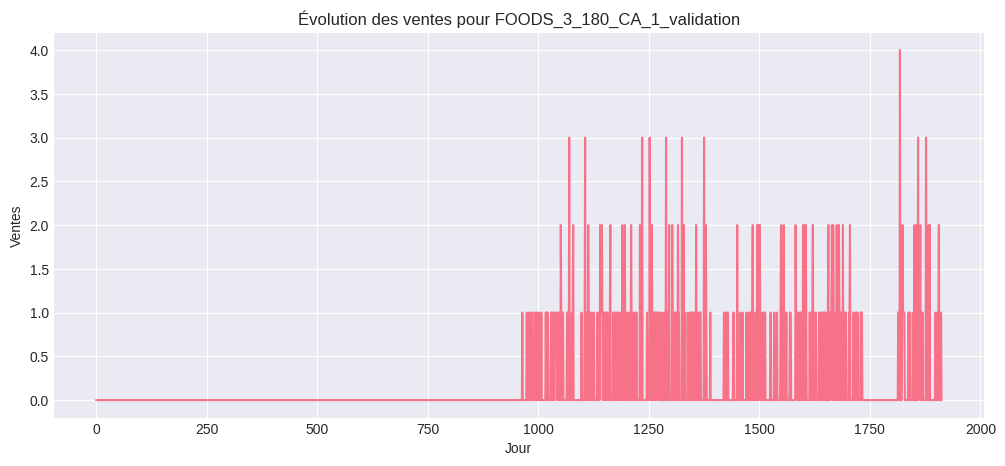

In [52]:
item_id = sales.sample(1, random_state=42)['id'].values[0]
ts = sales[sales['id'] == item_id].iloc[0, 6:].reset_index(drop=True)
plt.figure(figsize=(12,5))
plt.plot(ts)
plt.title(f'Évolution des ventes pour {item_id}')
plt.xlabel('Jour')
plt.ylabel('Ventes')
plt.show()

# RÉDUCTION DU DATASET (10 ARTICLES, 60-100 JOURS)

In [53]:


colonnes_ventes = [col for col in sales.columns if col.startswith('d_')]
sales['total_ventes'] = sales[colonnes_ventes].sum(axis=1)
sales['cv'] = sales[colonnes_ventes].std(axis=1) / (sales[colonnes_ventes].mean(axis=1) + 1)

# Sélection aléatoire par catégorie (1 ou 2 max par catégorie selon disponibilité)
articles_par_cat = []
for cat in sales['cat_id'].unique():
    cat_df = sales[sales['cat_id'] == cat]
    n = min(2, len(cat_df))  # max 2 ou moins si la catégorie est petite
    articles_par_cat.append(cat_df.sample(n, random_state=42))

articles_selectionnes = pd.concat(articles_par_cat).reset_index(drop=True)

# Si moins de 10, compléter aléatoirement parmi le reste
if len(articles_selectionnes) < 10:
    restants = sales[~sales['id'].isin(articles_selectionnes['id'])]
    n_rest = 10 - len(articles_selectionnes)
    articles_selectionnes = pd.concat([
        articles_selectionnes,
        restants.sample(n_rest, random_state=42)
    ]).reset_index(drop=True)
else:
    # Si plus de 10, prendre 10 aléatoirement
    articles_selectionnes = articles_selectionnes.sample(10, random_state=42).reset_index(drop=True)

articles_selectionnes_ids = articles_selectionnes['id'].tolist()
print("✅ Articles sélectionnés :", articles_selectionnes_ids)

# Sauvegarder
with open(f'{MODELS_PATH}/articles_selectionnes.pkl', 'wb') as f:
    pickle.dump(articles_selectionnes_ids, f)


✅ Articles sélectionnés : ['HOBBIES_1_190_TX_3_validation', 'HOBBIES_1_212_WI_1_validation', 'HOUSEHOLD_1_243_WI_1_validation', 'HOUSEHOLD_2_131_WI_1_validation', 'FOODS_2_007_TX_1_validation', 'FOODS_3_200_TX_3_validation', 'HOUSEHOLD_1_290_CA_4_validation', 'FOODS_3_015_WI_2_validation', 'HOBBIES_1_157_CA_4_validation', 'FOODS_1_135_TX_1_validation']


#RÉDUCTION DE LA PÉRIODE TEMPORELLE

In [54]:


JOUR_DEBUT = 1800
JOUR_FIN = 1900  # 100 jours
colonnes_periode = [f'd_{i}' for i in range(JOUR_DEBUT, JOUR_FIN)]
colonnes_id = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Filtrer sales
sales_reduit = sales[sales['id'].isin(articles_selectionnes_ids)][colonnes_id + colonnes_periode].copy()

# Filtrer calendar
calendar_reduit = calendar[calendar['d'].isin(colonnes_periode)].copy()
calendar_reduit['date'] = pd.to_datetime(calendar_reduit['date'])

# Filtrer prices
items_selectionnes = sales_reduit['item_id'].unique()
stores_selectionnes = sales_reduit['store_id'].unique()
wm_yr_wk_list = calendar_reduit['wm_yr_wk'].unique()

prices_reduit = prices[
    (prices['item_id'].isin(items_selectionnes)) &
    (prices['store_id'].isin(stores_selectionnes)) &
    (prices['wm_yr_wk'].isin(wm_yr_wk_list))
].copy()

# Sauvegarder
sales_reduit.to_csv(f'{DATA_PATH}/sales_reduit.csv', index=False)
calendar_reduit.to_csv(f'{DATA_PATH}/calendar_reduit.csv', index=False)
prices_reduit.to_csv(f'{DATA_PATH}/prices_reduit.csv', index=False)
print("✅ Données réduites sauvegardées")

✅ Données réduites sauvegardées


#VISUALISATION DES SÉRIES TEMPORELLES

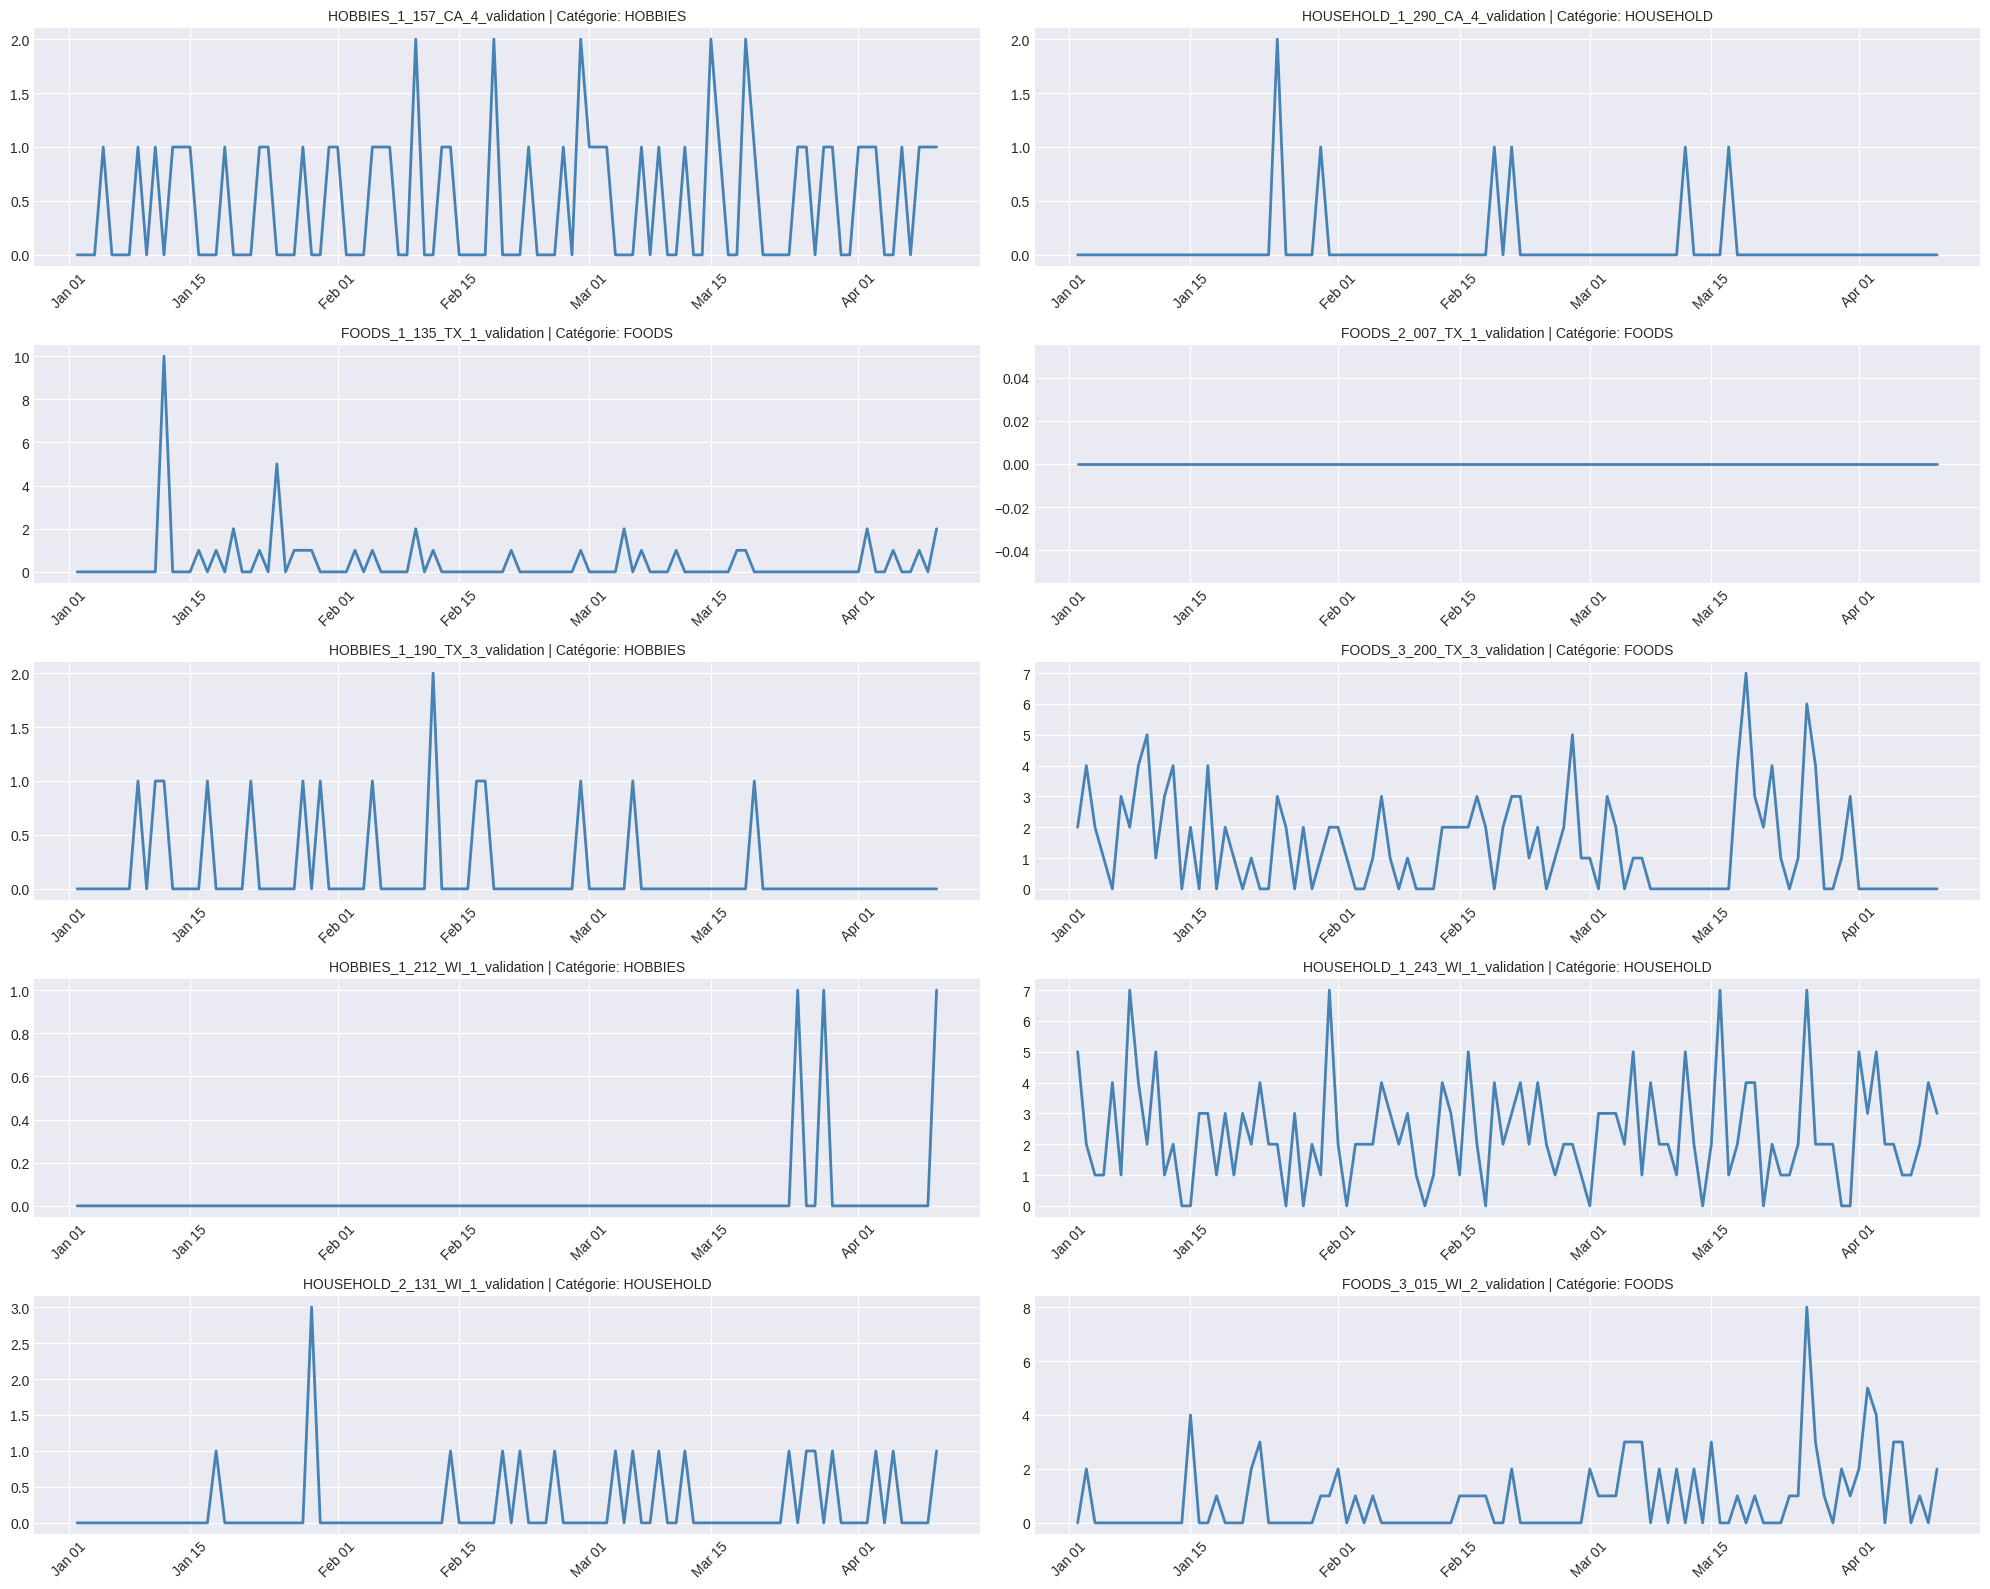

In [55]:


import matplotlib.dates as mdates

# Conversion des colonnes 'd_xxxx' en vraies dates
dates = calendar_reduit.set_index('d')['date']

# Création du graphique
fig, axes = plt.subplots(5, 2, figsize=(20, 16))
axes = axes.flatten()

for i, (idx, row) in enumerate(sales_reduit.iterrows()):
    if i >= 10:  # on limite à 10 produits
        break

    ventes = row[colonnes_periode].values
    jours = [dates[d] for d in colonnes_periode if d in dates.index]

    # Vérifie que la longueur correspond
    if len(jours) == len(ventes):
        axes[i].plot(jours, ventes, color='steelblue', linewidth=2)
        axes[i].set_title(f"{row['id']} | Catégorie: {row['cat_id']}", fontsize=10)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].text(0.5, 0.5, "Aucune donnée disponible", ha='center', va='center', fontsize=9)

plt.tight_layout()
plt.show()


#PRÉPARATION DES DONNÉES POUR LSTM/GRU/RNN

In [56]:
WINDOW_SIZE = 14
HORIZON = 1
TEST_SIZE = 0.2

X_all, y_all = [], []
scalers = {}

for idx, row in sales_reduit.iterrows():
    article_id = row['id']
    ventes = row[colonnes_periode].values.astype(float)

    scaler = MinMaxScaler()
    ventes_scaled = scaler.fit_transform(ventes.reshape(-1,1)).flatten()
    scalers[article_id] = scaler

    for i in range(len(ventes_scaled) - WINDOW_SIZE - HORIZON + 1):
        X_all.append(ventes_scaled[i:i+WINDOW_SIZE])
        y_all.append(ventes_scaled[i+WINDOW_SIZE:i+WINDOW_SIZE+HORIZON])

X_all = np.array(X_all).reshape(-1, WINDOW_SIZE,1)
y_all = np.array(y_all)

split_idx = int(len(X_all)*(1-TEST_SIZE))
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

with open(f'{MODELS_PATH}/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)


#DÉFINITION DES MODÈLES

In [57]:
UNITS = 64
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001

def creer_lstm(window_size):
    model = Sequential([
        LSTM(UNITS, activation='relu', return_sequences=True, input_shape=(window_size,1)),
        Dropout(DROPOUT_RATE),
        LSTM(UNITS//2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(UNITS//4, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss='mse', metrics=['mae','mape'])
    return model

def creer_gru(window_size):
    model = Sequential([
        GRU(UNITS, activation='relu', return_sequences=True, input_shape=(window_size,1)),
        Dropout(DROPOUT_RATE),
        GRU(UNITS//2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(UNITS//4, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss='mse', metrics=['mae','mape'])
    return model

def creer_rnn(window_size):
    model = Sequential([
        SimpleRNN(UNITS, activation='relu', return_sequences=True, input_shape=(window_size,1)),
        Dropout(DROPOUT_RATE),
        SimpleRNN(UNITS//2, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(UNITS//4, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss='mse', metrics=['mae','mape'])
    return model


#CRÉATION DES SÉQUENCES  

In [58]:


def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# On utilise les ventes réduites de sales_reduit
article_id = sales_reduit['id'].iloc[0]
serie = sales_reduit.iloc[0, 6:].values.astype(float).reshape(-1, 1)

# Mise à l’échelle
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(serie)

WINDOW_SIZE = 30
X, y = create_sequences(data_scaled, WINDOW_SIZE)

print("✅ Données séquentielles créées :", X.shape, y.shape)

# Découpage train/test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


✅ Données séquentielles créées : (70, 30, 1) (70, 1)


# ENTRAÎNEMENT DU MODÈLE LSTM  


In [59]:


model_lstm = creer_lstm(WINDOW_SIZE)

checkpoint_lstm = ModelCheckpoint(
    filepath=f"{MODELS_PATH}/lstm_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[checkpoint_lstm, early_stop],
    verbose=1
)

# Sauvegarde de l’historique
with open(f'{MODELS_PATH}/lstm_history.pkl', 'wb') as f:
    pickle.dump(history_lstm.history, f)

print("✅ LSTM entraîné et sauvegardé :", f"{MODELS_PATH}/lstm_model.h5")


Epoch 1/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - loss: 0.2104 - mae: 0.2966 - mape: 9457136.0000
Epoch 1: val_loss improved from inf to 0.15981, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 728ms/step - loss: 0.1853 - mae: 0.2715 - mape: 6122588.5000 - val_loss: 0.1598 - val_mae: 0.2518 - val_mape: 7644894.5000
Epoch 2/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1802 - mae: 0.2534 - mape: 8987940.0000
Epoch 2: val_loss improved from 0.15981 to 0.14834, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1659 - mae: 0.2539 - mape: 11658877.0000 - val_loss: 0.1483 - val_mae: 0.2570 - val_mape: 23591280.0000
Epoch 3/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1674 - mae: 0.2592 - mape: 25340616.0000
Epoch 3: val_loss improved from 0.14834 to 0.13764, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.1575 - mae: 0.2653 - mape: 26305260.0000 - val_loss: 0.1376 - val_mae: 0.2622 - val_mape: 40328932.0000
Epoch 4/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0493 - mae: 0.1570 - mape: 49880568.0000
Epoch 4: val_loss improved from 0.13764 to 0.12775, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1186 - mae: 0.2404 - mape: 45541404.0000 - val_loss: 0.1278 - val_mae: 0.2676 - val_mape: 58151420.0000
Epoch 5/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0556 - mae: 0.1864 - mape: 61407472.0000
Epoch 5: val_loss improved from 0.12775 to 0.11808, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.1035 - mae: 0.2389 - mape: 60159544.0000 - val_loss: 0.1181 - val_mae: 0.2740 - val_mape: 79839264.0000
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1325 - mae: 0.3163 - mape: 50216224.0000
Epoch 6: val_loss improved from 0.11808 to 0.10948, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.1259 - mae: 0.2927 - mape: 77218048.0000 - val_loss: 0.1095 - val_mae: 0.2821 - val_mape: 108055112.0000
Epoch 7/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1328 - mae: 0.2928 - mape: 107938680.0000
Epoch 7: val_loss improved from 0.10948 to 0.10529, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1216 - mae: 0.2865 - mape: 107754200.0000 - val_loss: 0.1053 - val_mae: 0.2925 - val_mape: 144062352.0000
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0990 - mae: 0.2885 - mape: 147648384.0000 
Epoch 8: val_loss did not improve from 0.10529
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.1018 - mae: 0.2910 - mape: 149331232.0000 - val_loss: 0.1083 - val_mae: 0.3022 - val_mape: 178053392.0000
Epoch 9/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0973 - mae: 0.2865 - mape: 159824320.0000
Epoch 9: val_loss did not improve from 0.10529
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.1132 - mae: 0.3057 - mape: 179101968.0000 - val_loss: 0.1088 - val_mae: 0.3030 - val_mape: 180424384.0000
Epoch 10/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1210 - mae: 0.3073 - mape: 158356688.0000
Epoch 10: val_loss did not improve from 0.10529
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1124 - mae: 0.2974 - mape: 166263824.0000 -

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1039 - mae: 0.2947 - mape: 162790240.0000 - val_loss: 0.1052 - val_mae: 0.2947 - val_mape: 152290144.0000
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0997 - mae: 0.2864 - mape: 152771664.0000
Epoch 12: val_loss improved from 0.10525 to 0.10506, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1021 - mae: 0.2884 - mape: 150804064.0000 - val_loss: 0.1051 - val_mae: 0.2926 - val_mape: 145333664.0000
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0928 - mae: 0.2810 - mape: 144162912.0000
Epoch 13: val_loss improved from 0.10506 to 0.10501, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0978 - mae: 0.2854 - mape: 143364256.0000 - val_loss: 0.1050 - val_mae: 0.2920 - val_mape: 143344848.0000
Epoch 14/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.1698 - mae: 0.3479 - mape: 117746832.0000
Epoch 14: val_loss improved from 0.10501 to 0.10492, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1309 - mae: 0.3111 - mape: 134274368.0000 - val_loss: 0.1049 - val_mae: 0.2927 - val_mape: 146197584.0000
Epoch 15/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0982 - mae: 0.2762 - mape: 143235440.0000
Epoch 15: val_loss improved from 0.10492 to 0.10486, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1068 - mae: 0.2877 - mape: 141735584.0000 - val_loss: 0.1049 - val_mae: 0.2926 - val_mape: 146409456.0000
Epoch 16/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1388 - mae: 0.3245 - mape: 155347936.0000
Epoch 16: val_loss improved from 0.10486 to 0.10479, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1251 - mae: 0.3116 - mape: 149473424.0000 - val_loss: 0.1048 - val_mae: 0.2927 - val_mape: 147047920.0000
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0982 - mae: 0.2801 - mape: 143049520.0000 
Epoch 17: val_loss improved from 0.10479 to 0.10470, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1008 - mae: 0.2828 - mape: 142596208.0000 - val_loss: 0.1047 - val_mae: 0.2923 - val_mape: 145946672.0000
Epoch 18/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1201 - mae: 0.3061 - mape: 139338592.0000
Epoch 18: val_loss improved from 0.10470 to 0.10462, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1108 - mae: 0.2968 - mape: 142924416.0000 - val_loss: 0.1046 - val_mae: 0.2922 - val_mape: 145993040.0000
Epoch 19/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0663 - mae: 0.2566 - mape: 125877984.0000
Epoch 19: val_loss improved from 0.10462 to 0.10455, saving model to /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1011 - mae: 0.2895 - mape: 137463776.0000 - val_loss: 0.1046 - val_mae: 0.2920 - val_mape: 145811472.0000
Epoch 20/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1219 - mae: 0.3071 - mape: 153601952.0000
Epoch 20: val_loss did not improve from 0.10455
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1143 - mae: 0.2966 - mape: 142964288.0000 - val_loss: 0.1046 - val_mae: 0.2915 - val_mape: 144269600.0000
✅ LSTM entraîné et sauvegardé : /content/drive/MyDrive/M5_Forecasting/models/lstm_model.h5


# ENTRAÎNEMENT DU MODÈLE GRU  


In [60]:


model_gru = creer_gru(WINDOW_SIZE)

checkpoint_gru = ModelCheckpoint(
    filepath=f"{MODELS_PATH}/gru_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_gru = model_gru.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[checkpoint_gru, early_stop_gru],
    verbose=1
)

with open(f'{MODELS_PATH}/gru_history.pkl', 'wb') as f:
    pickle.dump(history_gru.history, f)

print("✅ GRU entraîné et sauvegardé :", f"{MODELS_PATH}/gru_model.h5")


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1299 - mae: 0.2106 - mape: 22480182.0000
Epoch 1: val_loss improved from inf to 0.13290, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 710ms/step - loss: 0.1361 - mae: 0.2224 - mape: 22713172.0000 - val_loss: 0.1329 - val_mae: 0.2702 - val_mape: 54990780.0000
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1648 - mae: 0.2919 - mape: 46949740.0000
Epoch 2: val_loss improved from 0.13290 to 0.11651, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.1567 - mae: 0.2839 - mape: 47816196.0000 - val_loss: 0.1165 - val_mae: 0.2867 - val_mape: 101598720.0000
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1194 - mae: 0.2719 - mape: 89357528.0000
Epoch 3: val_loss improved from 0.11651 to 0.11134, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1187 - mae: 0.2731 - mape: 90850080.0000 - val_loss: 0.1113 - val_mae: 0.3023 - val_mape: 147774640.0000
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0962 - mae: 0.2878 - mape: 155566608.0000
Epoch 4: val_loss did not improve from 0.11134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1016 - mae: 0.2929 - mape: 153820480.0000 - val_loss: 0.1146 - val_mae: 0.3129 - val_mape: 180513328.0000
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1217 - mae: 0.3040 - mape: 170666016.0000
Epoch 5: val_loss did not improve from 0.11134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.1194 - mae: 0.3011 - mape: 168300640.0000 - val_loss: 0.1186 - val_mae: 0.3182 - val_mape: 198302960.0000
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1172 - mae: 0.3129 - mape: 192330208.0000
Epoch 6: val_loss did not improve from 0.11134
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1172 - mae: 0.3120 - mape: 190692448.0000 - va

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1185 - mae: 0.3161 - mape: 183640704.0000 - val_loss: 0.1095 - val_mae: 0.3023 - val_mape: 156385520.0000
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0917 - mae: 0.2768 - mape: 152928800.0000
Epoch 9: val_loss improved from 0.10950 to 0.10872, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0990 - mae: 0.2835 - mape: 150138080.0000 - val_loss: 0.1087 - val_mae: 0.2954 - val_mape: 137469584.0000
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1308 - mae: 0.3104 - mape: 131098848.0000
Epoch 10: val_loss improved from 0.10872 to 0.10858, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1272 - mae: 0.3066 - mape: 130698160.0000 - val_loss: 0.1086 - val_mae: 0.2919 - val_mape: 129126360.0000
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1141 - mae: 0.2913 - mape: 113379944.0000
Epoch 11: val_loss improved from 0.10858 to 0.10817, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1144 - mae: 0.2906 - mape: 113829960.0000 - val_loss: 0.1082 - val_mae: 0.2904 - val_mape: 126997608.0000
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1150 - mae: 0.2851 - mape: 141353072.0000
Epoch 12: val_loss improved from 0.10817 to 0.10760, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1149 - mae: 0.2866 - mape: 136846992.0000 - val_loss: 0.1076 - val_mae: 0.2896 - val_mape: 126837240.0000
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1213 - mae: 0.2993 - mape: 111344648.0000
Epoch 13: val_loss improved from 0.10760 to 0.10642, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1193 - mae: 0.2969 - mape: 113974872.0000 - val_loss: 0.1064 - val_mae: 0.2911 - val_mape: 134222912.0000
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1005 - mae: 0.2797 - mape: 144783184.0000
Epoch 14: val_loss improved from 0.10642 to 0.10564, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.1036 - mae: 0.2833 - mape: 141293744.0000 - val_loss: 0.1056 - val_mae: 0.2916 - val_mape: 138363920.0000
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1133 - mae: 0.2970 - mape: 138678528.0000
Epoch 15: val_loss improved from 0.10564 to 0.10488, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1147 - mae: 0.2987 - mape: 139728208.0000 - val_loss: 0.1049 - val_mae: 0.2927 - val_mape: 144873968.0000
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1192 - mae: 0.3054 - mape: 151354208.0000
Epoch 16: val_loss improved from 0.10488 to 0.10434, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1178 - mae: 0.3038 - mape: 151138960.0000 - val_loss: 0.1043 - val_mae: 0.2932 - val_mape: 149332304.0000
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1070 - mae: 0.2965 - mape: 172296656.0000
Epoch 17: val_loss improved from 0.10434 to 0.10379, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1093 - mae: 0.2984 - mape: 166906224.0000 - val_loss: 0.1038 - val_mae: 0.2913 - val_mape: 145224720.0000
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1371 - mae: 0.3231 - mape: 135502496.0000
Epoch 18: val_loss improved from 0.10379 to 0.10329, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1309 - mae: 0.3171 - mape: 137841824.0000 - val_loss: 0.1033 - val_mae: 0.2903 - val_mape: 144562928.0000
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0849 - mae: 0.2697 - mape: 139150896.0000 
Epoch 19: val_loss improved from 0.10329 to 0.10283, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0900 - mae: 0.2753 - mape: 141492432.0000 - val_loss: 0.1028 - val_mae: 0.2884 - val_mape: 140506384.0000
Epoch 20/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1151 - mae: 0.3026 - mape: 145111920.0000
Epoch 20: val_loss improved from 0.10283 to 0.10238, saving model to /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.1130 - mae: 0.2995 - mape: 143968192.0000 - val_loss: 0.1024 - val_mae: 0.2865 - val_mape: 137061520.0000
✅ GRU entraîné et sauvegardé : /content/drive/MyDrive/M5_Forecasting/models/gru_model.h5


# ENTRAÎNEMENT DU MODÈLE RNN  


In [61]:


model_rnn = creer_rnn(WINDOW_SIZE)

checkpoint_rnn = ModelCheckpoint(
    filepath=f"{MODELS_PATH}/rnn_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop_rnn = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    callbacks=[checkpoint_rnn, early_stop_rnn],
    verbose=1
)

with open(f'{MODELS_PATH}/rnn_history.pkl', 'wb') as f:
    pickle.dump(history_rnn.history, f)

print("✅ RNN entraîné et sauvegardé :", f"{MODELS_PATH}/rnn_model.h5")


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2210 - mae: 0.3099 - mape: 20082924.0000
Epoch 1: val_loss improved from inf to 0.15803, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 718ms/step - loss: 0.2065 - mae: 0.2987 - mape: 21493596.0000 - val_loss: 0.1580 - val_mae: 0.2835 - val_mape: 48491248.0000
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2082 - mae: 0.3094 - mape: 34691140.0000
Epoch 2: val_loss improved from 0.15803 to 0.15323, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.1947 - mae: 0.2980 - mape: 34398108.0000 - val_loss: 0.1532 - val_mae: 0.2866 - val_mape: 60995092.0000
Epoch 3/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2223 - mae: 0.3212 - mape: 33239852.0000
Epoch 3: val_loss improved from 0.15323 to 0.14713, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1664 - mae: 0.2815 - mape: 45513048.0000 - val_loss: 0.1471 - val_mae: 0.2908 - val_mape: 77517984.0000
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1357 - mae: 0.2736 - mape: 79129456.0000
Epoch 4: val_loss improved from 0.14713 to 0.13941, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1371 - mae: 0.2747 - mape: 76584048.0000 - val_loss: 0.1394 - val_mae: 0.2967 - val_mape: 98517984.0000
Epoch 5/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0747 - mae: 0.2368 - mape: 100617528.0000
Epoch 5: val_loss improved from 0.13941 to 0.13125, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.1109 - mae: 0.2662 - mape: 89851456.0000 - val_loss: 0.1312 - val_mae: 0.3035 - val_mape: 121040160.0000
Epoch 6/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0862 - mae: 0.2343 - mape: 107218072.0000
Epoch 6: val_loss improved from 0.13125 to 0.12301, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1226 - mae: 0.2742 - mape: 94634360.0000 - val_loss: 0.1230 - val_mae: 0.3082 - val_mape: 143352624.0000
Epoch 7/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0967 - mae: 0.2578 - mape: 101978056.0000
Epoch 7: val_loss improved from 0.12301 to 0.11901, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.1188 - mae: 0.2873 - mape: 118662936.0000 - val_loss: 0.1190 - val_mae: 0.3122 - val_mape: 164157616.0000
Epoch 8/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1132 - mae: 0.2796 - mape: 93547424.0000
Epoch 8: val_loss improved from 0.11901 to 0.11776, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1170 - mae: 0.2837 - mape: 115801272.0000 - val_loss: 0.1178 - val_mae: 0.3149 - val_mape: 183791792.0000
Epoch 9/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1518 - mae: 0.3209 - mape: 148608768.0000
Epoch 9: val_loss improved from 0.11776 to 0.11523, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.1346 - mae: 0.3121 - mape: 151791296.0000 - val_loss: 0.1152 - val_mae: 0.3121 - val_mape: 185802032.0000
Epoch 10/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0933 - mae: 0.2743 - mape: 168204384.0000
Epoch 10: val_loss improved from 0.11523 to 0.11199, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0989 - mae: 0.2749 - mape: 148607488.0000 - val_loss: 0.1120 - val_mae: 0.3071 - val_mape: 178056896.0000
Epoch 11/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0900 - mae: 0.2628 - mape: 115770504.0000
Epoch 11: val_loss improved from 0.11199 to 0.10880, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0980 - mae: 0.2736 - mape: 132678496.0000 - val_loss: 0.1088 - val_mae: 0.3021 - val_mape: 174091328.0000
Epoch 12/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1226 - mae: 0.2797 - mape: 90165304.0000
Epoch 12: val_loss improved from 0.10880 to 0.10665, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.1090 - mae: 0.2705 - mape: 123749104.0000 - val_loss: 0.1066 - val_mae: 0.2987 - val_mape: 170072336.0000
Epoch 13/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0855 - mae: 0.2660 - mape: 176065392.0000
Epoch 13: val_loss improved from 0.10665 to 0.10504, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0992 - mae: 0.2771 - mape: 154182688.0000 - val_loss: 0.1050 - val_mae: 0.2950 - val_mape: 158088528.0000
Epoch 14/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1037 - mae: 0.2674 - mape: 96499656.0000
Epoch 14: val_loss improved from 0.10504 to 0.10460, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.0986 - mae: 0.2675 - mape: 117512840.0000 - val_loss: 0.1046 - val_mae: 0.2936 - val_mape: 154802992.0000
Epoch 15/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0499 - mae: 0.2115 - mape: 142669792.0000
Epoch 15: val_loss improved from 0.10460 to 0.10351, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0810 - mae: 0.2498 - mape: 126262984.0000 - val_loss: 0.1035 - val_mae: 0.2913 - val_mape: 152220880.0000
Epoch 16/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0903 - mae: 0.2706 - mape: 161517600.0000
Epoch 16: val_loss improved from 0.10351 to 0.10142, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0951 - mae: 0.2713 - mape: 141992160.0000 - val_loss: 0.1014 - val_mae: 0.2889 - val_mape: 154753520.0000
Epoch 17/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1713 - mae: 0.3501 - mape: 131545576.0000
Epoch 17: val_loss improved from 0.10142 to 0.10029, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.1306 - mae: 0.3087 - mape: 138443952.0000 - val_loss: 0.1003 - val_mae: 0.2881 - val_mape: 160406736.0000
Epoch 18/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0837 - mae: 0.2487 - mape: 122302504.0000
Epoch 18: val_loss improved from 0.10029 to 0.09914, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0887 - mae: 0.2553 - mape: 136005712.0000 - val_loss: 0.0991 - val_mae: 0.2857 - val_mape: 153671728.0000
Epoch 19/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1059 - mae: 0.2730 - mape: 150904000.0000
Epoch 19: val_loss improved from 0.09914 to 0.09768, saving model to /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1021 - mae: 0.2751 - mape: 132354688.0000 - val_loss: 0.0977 - val_mae: 0.2818 - val_mape: 146711664.0000
Epoch 20/20
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1162 - mae: 0.2886 - mape: 145270208.0000
Epoch 20: val_loss did not improve from 0.09768
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1056 - mae: 0.2742 - mape: 126254440.0000 - val_loss: 0.0981 - val_mae: 0.2814 - val_mape: 146038608.0000
✅ RNN entraîné et sauvegardé : /content/drive/MyDrive/M5_Forecasting/models/rnn_model.h5


#ÉVALUATION ET COMPARAISON

In [62]:


models = {
    'LSTM': (model_lstm, 'lstm_model.h5'),
    'GRU': (model_gru, 'gru_model.h5'),
    'RNN': (model_rnn, 'rnn_model.h5')
}

for name, (model, path) in models.items():
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    print(f"\n📈 {name} - MSE: {mse:.4f}, MAE: {mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step

📈 LSTM - MSE: 0.0633, MAE: 0.2516


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step

📈 GRU - MSE: 0.0647, MAE: 0.2533


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step

📈 RNN - MSE: 0.0652, MAE: 0.2451


##  CELLULE FINALE : COMPARAISON DES COURBES D’ENTRAÎNEMENT (LSTM / GRU / RNN)


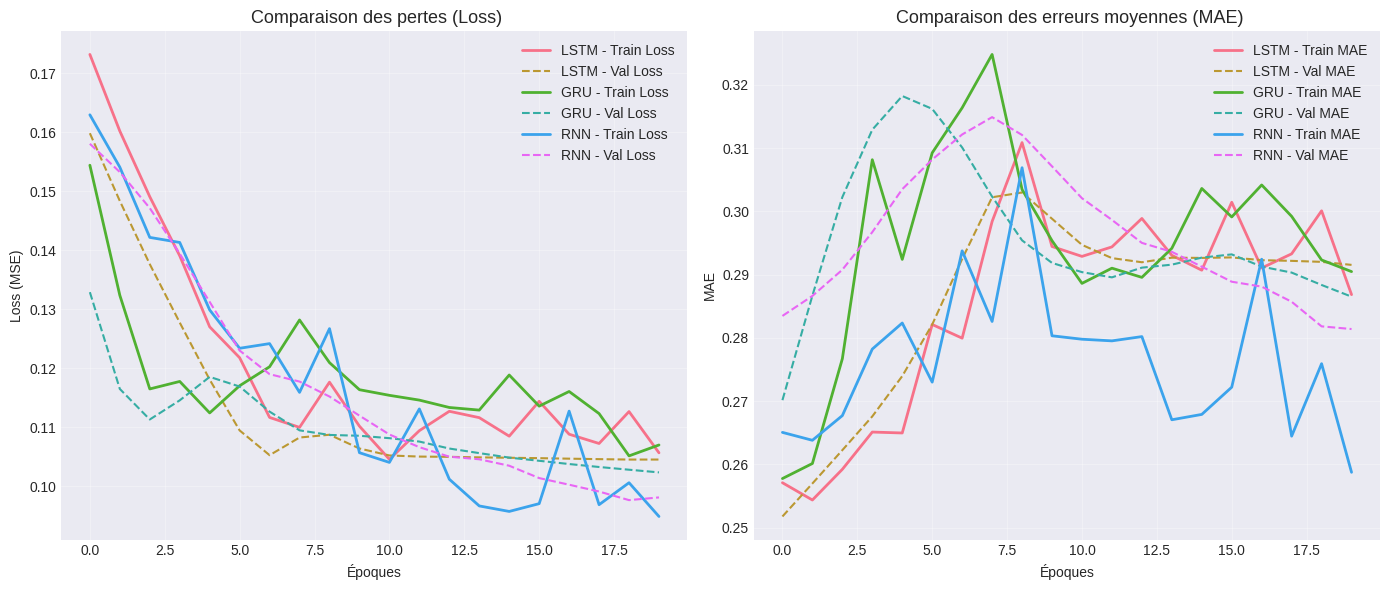

In [63]:


import matplotlib.pyplot as plt

# --- Vérification de la présence des historiques ---
histories = {
    "LSTM": history_lstm if "history_lstm" in locals() else None,
    "GRU": history_gru if "history_gru" in locals() else None,
    "RNN": history_rnn if "history_rnn" in locals() else None,
}

# --- Initialisation du graphique ---
plt.figure(figsize=(14, 6))

# --- Courbes de LOSS ---
plt.subplot(1, 2, 1)
for name, hist in histories.items():
    if hist:
        plt.plot(hist.history['loss'], label=f'{name} - Train Loss', linewidth=2)
        plt.plot(hist.history['val_loss'], linestyle='--', label=f'{name} - Val Loss', linewidth=1.5)
plt.title(' Comparaison des pertes (Loss)', fontsize=13)
plt.xlabel('Époques')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(alpha=0.3)

# --- Courbes de MAE ---
plt.subplot(1, 2, 2)
for name, hist in histories.items():
    if hist and 'mae' in hist.history:
        plt.plot(hist.history['mae'], label=f'{name} - Train MAE', linewidth=2)
        plt.plot(hist.history['val_mae'], linestyle='--', label=f'{name} - Val MAE', linewidth=1.5)
plt.title(' Comparaison des erreurs moyennes (MAE)', fontsize=13)
plt.xlabel('Époques')
plt.ylabel('MAE')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
